## Setting up the environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install nltk

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords

## Loading dataset

In [4]:
import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df.shape

(7613, 5)

In [ ]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

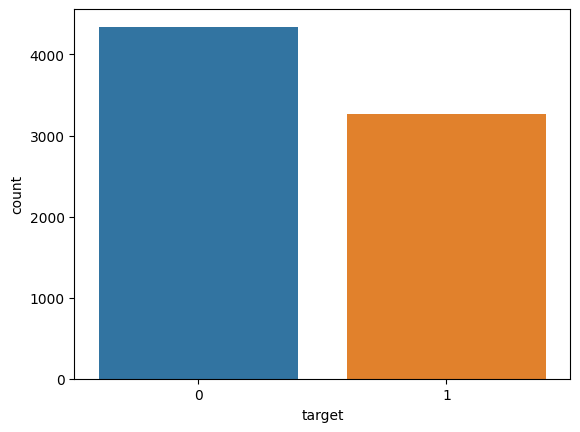

In [ ]:
sns.countplot(data = train_df, x='target')
plt.show()

In [5]:
avg_disaster_tweet=train_df[train_df['target']==1]['target'].count()
avg_non_disaster_tweet=train_df[train_df['target']==0]['target'].count()

print(f'The average of disaster tweets:',avg_disaster_tweet/100,'%')
print(f'The average of non-disaster tweets:',avg_non_disaster_tweet/100,'%')

The average of disaster tweets: 32.71 %
The average of non-disaster tweets: 43.42 %


## Data preprocessing

In [6]:
import re
import string
from nltk.corpus import stopwords

def clean_text(text):

    # Convert all to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize the text
    words = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))

    cleaned_words = [word for word in words if word.lower() not in stop_words]

    return ' '.join(cleaned_words)

# Apply the cleaning function to the column
train_df['text'] = train_df['text'].apply(clean_text)

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


## Getting top 20 keywords

In [7]:
train_disaster_tweet_df=train_df[train_df['target']==1]

In [ ]:
train_disaster_tweet_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer for unigrams
tfidf_vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1, 1))  # Use ngram_range=(1, 1) for unigrams

# Fit and transform the cleaned text column for unigrams
tfidf_matrix = tfidf_vectorizer.fit_transform(train_disaster_tweet_df['text'])

# Get the feature names (words) for unigrams
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame to store the TF-IDF values for unigrams
tfidf_values_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=feature_names)

# Calculate the sum of TF-IDF scores for each document for unigrams
sum_tfidf_per_doc = tfidf_values_df.sum(axis=1)

# Normalize the TF-IDF matrix for unigrams by dividing each row by its sum
normalized_tfidf_matrix = tfidf_values_df.div(sum_tfidf_per_doc, axis=0)

# Get the mean across all documents for unigrams to get normalized TF-IDF scores for each word
normalized_tfidf_scores = normalized_tfidf_matrix.mean()

# Get the top 20 keywords for unigrams
top_20_keywords_normalized = normalized_tfidf_scores.nlargest(20)

print(top_20_keywords_normalized)

fire          0.082599
news          0.068703
via           0.064876
suicide       0.059071
disaster      0.056018
hiroshima     0.053596
people        0.051887
storm         0.051639
california    0.050628
like          0.050256
police        0.050155
amp           0.048136
train         0.044502
pm            0.043756
crash         0.042156
us            0.041516
fires         0.040576
buildings     0.036131
killed        0.034685
families      0.029115
dtype: float64


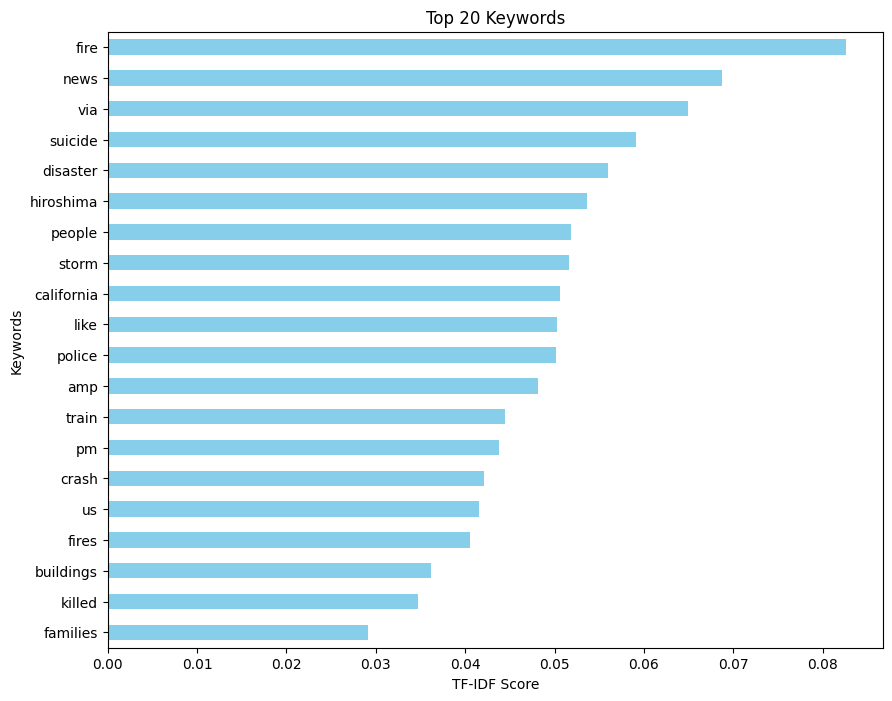

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Sort the values in ascending order
top_20_keywords_normalized = top_20_keywords_normalized.sort_values(ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
top_20_keywords_normalized.plot(kind='barh', color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 20 Keywords')
plt.show()

## Location Field

In [10]:
avg_disaster_tweet_df=train_df[train_df['target']==1]

In [11]:
# Define a mapping for place names
place_mapping = {
    'USA': 'United States',
    'US': 'United States',
    'Washington, D.C.': 'Washington, DC',
    'Wahington, DC': 'Washington, DC',
    'New York, NY': 'New York',
    'California, USA': 'California',
    'Los Angeles': 'Los Angeles, CA',
    'CLos Angeles, CA': 'Los Angeles, CA',
}

# Apply the mapping using replace
avg_disaster_tweet_df['location'] = avg_disaster_tweet_df['location'].replace(place_mapping)

<ipython-input-11-974ae51a284c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_disaster_tweet_df['location'] = avg_disaster_tweet_df['location'].replace(place_mapping)


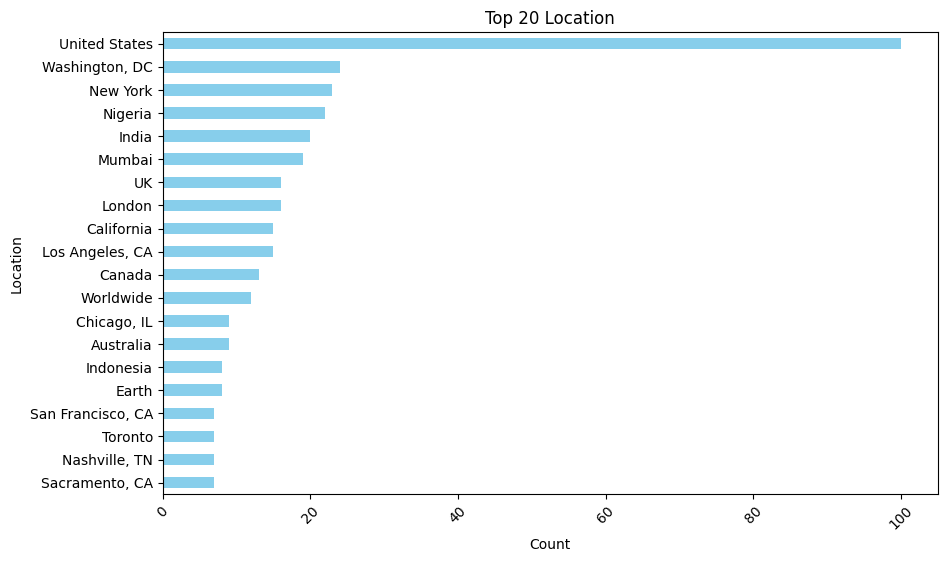

In [12]:
import matplotlib.pyplot as plt
# Count the values in the 'Category' column
category_counts = avg_disaster_tweet_df['location'].value_counts()

# Select the top 20 categories
top_20_categories = category_counts.head(20).sort_values(ascending=True)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_20_categories.plot(kind='barh', color='skyblue')
plt.title('Top 20 Location')
plt.ylabel('Location')
plt.xlabel('Count')
plt.xticks(rotation=45)
plt.show()

## Keyword Field

In [13]:
# Define a mapping for place names
keyword_mapping = {
    'evacuated': 'evacuation',
    'suicide bomber': 'suicide bombing',
    'suicide bomb': 'suicide bombing',
}

# Apply the mapping using replace
avg_disaster_tweet_df['keyword'] = avg_disaster_tweet_df['keyword'].replace(keyword_mapping)

<ipython-input-13-0a25ef3dfa43>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_disaster_tweet_df['keyword'] = avg_disaster_tweet_df['keyword'].replace(keyword_mapping)


In [14]:
# Define a function to remove digits from a string
def remove_digits(text):
    if isinstance(text, str):
        return re.sub(r'[\d%]+', ' ', text)
    else:
        return text

# Apply the function to the column
avg_disaster_tweet_df['keyword'] = avg_disaster_tweet_df['keyword'].apply(remove_digits)

<ipython-input-14-16d586c072dd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_disaster_tweet_df['keyword'] = avg_disaster_tweet_df['keyword'].apply(remove_digits)


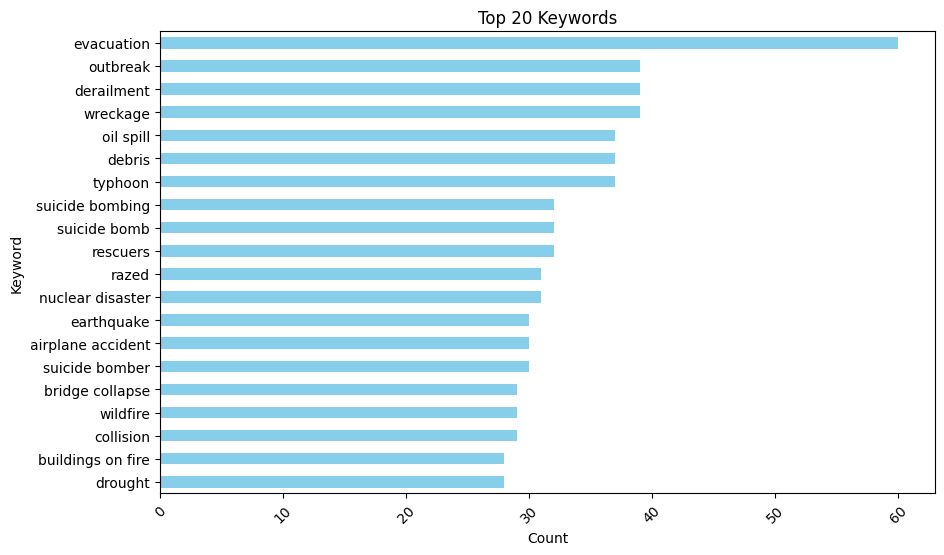

In [15]:
# Count the values in the 'Category' column
category_counts = avg_disaster_tweet_df['keyword'].value_counts()

# Select the top 20 categories
top_20_categories = category_counts.head(20).sort_values(ascending=True)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_20_categories.plot(kind='barh', color='skyblue')
plt.title('Top 20 Keywords')
plt.ylabel('Keyword')
plt.xlabel('Count')
plt.xticks(rotation=45)
plt.show()